# MoCo Self-Supervised Learning (pretraining)

***backbone***: Resnet-18

***using simulated multiple GPUs parallel computing in only one GPU***


In [2]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torchvision.datasets as datasets
#from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


Wed Apr 20 12:31:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   45C    P0    44W / 300W |      0MiB / 16160MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set arguments

In [17]:
parser = argparse.ArgumentParser(description='Train MoCo on LUNA')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.03, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=1000, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')

parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--train-dir',default='/projectnb/dl523/projects/COVIDCT2/dataset/LUNA/',type=str, help='path to training data (default:LUNA folder)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')

'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
#args.resume = 'cache-2022-04-14-16-10-30-moco/model_last.pth'
#args.results_dir = './cache-2022-04-14-16-10-30-moco/'
args.epochs = 140
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False

args.results_dir = './Covid-cache/cache-moco-Cifar-Luna-Covid'

print(args)

Namespace(arch='resnet18', batch_size=128, bn_splits=8, cos=True, epochs=140, knn_k=200, knn_t=0.1, lr=0.03, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, results_dir='./Covid-cache/cache-moco-Cifar-Luna-Covid', resume='', schedule=[], symmetric=False, train_dir='/projectnb/dl523/projects/COVIDCT2/dataset/LUNA/', wd=0.0005)


### Define data loaders

In [29]:
#for CIFAR10 dataset

class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """
    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            im_1 = self.transform(img)
            im_2 = self.transform(img)

        return im_1, im_2

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])



# data prepare
train_data = CIFAR10Pair(root='cifardataset', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

memory_data = CIFAR10(root='cifardataset', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='cifardataset', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
#for LUNA dataset

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomResizedCrop(64, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])




class LUNAPair(Dataset):
    def __init__(self, root_dir,transform):
        self.root_dir = root_dir
        self.data_set = datasets.ImageFolder(self.root_dir)
        self.transform = transform 
    def __len__(self):
        return len(self.data_set)
    
    def __getitem__(self, idx):
        img = self.data_set[idx][0]

        if self.transform is not None:
            im_1 = self.transform(img)
            im_2 = self.transform(img)
            
        return im_1, im_2
    
# data prepare
train_data = LUNAPair(root_dir = args.train_dir,transform=train_transform)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)


In [13]:
#for COVIDCT dataset

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])

train_transformer = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomResizedCrop((64),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

class CovidCTPair(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        
        return image1,image2

    

train_data = CovidCTPair(root_dir='/projectnb/dl523/projects/COVIDCT2/dataset/COVIDCT',
                              txt_COVID='/projectnb/dl523/projects/COVIDCT2/dataset/COVID-Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='/projectnb/dl523/projects/COVIDCT2/dataset/COVID-Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
   
train_loader = DataLoader(train_data, batch_size=args.batch_size,drop_last=True, shuffle=True, num_workers=16)    
#train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)


### Example: Two Augmented (query and key input ) Images from the singe image input ###

0


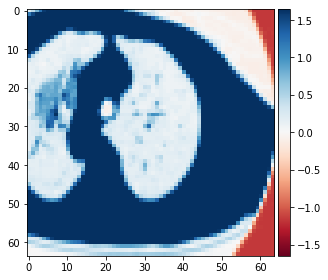

In [32]:
import skimage.io 
for i,image in enumerate(train_loader): 
    print(i)
    break 

skimage.io.imshow(image[0][15,0,:,:].numpy())  

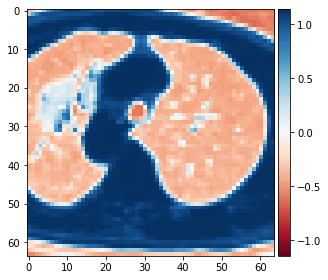

In [33]:
skimage.io.imshow(image[1][15,0,:,:].numpy())  

### Define base encoder

In [5]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

### Define MoCo wrapper

In [6]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss



### Define train/test



In [7]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for im_1, im_2 in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2)
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

### Creat Encoder Network and Model Info 

In [14]:
# create model
model = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).cuda()
print(model.encoder_q)

ModelBase(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel

In [15]:
model.encoder_q.state_dict().keys()

odict_keys(['net.0.weight', 'net.1.weight', 'net.1.bias', 'net.1.running_mean', 'net.1.running_var', 'net.1.num_batches_tracked', 'net.3.0.conv1.weight', 'net.3.0.bn1.weight', 'net.3.0.bn1.bias', 'net.3.0.bn1.running_mean', 'net.3.0.bn1.running_var', 'net.3.0.bn1.num_batches_tracked', 'net.3.0.conv2.weight', 'net.3.0.bn2.weight', 'net.3.0.bn2.bias', 'net.3.0.bn2.running_mean', 'net.3.0.bn2.running_var', 'net.3.0.bn2.num_batches_tracked', 'net.3.1.conv1.weight', 'net.3.1.bn1.weight', 'net.3.1.bn1.bias', 'net.3.1.bn1.running_mean', 'net.3.1.bn1.running_var', 'net.3.1.bn1.num_batches_tracked', 'net.3.1.conv2.weight', 'net.3.1.bn2.weight', 'net.3.1.bn2.bias', 'net.3.1.bn2.running_mean', 'net.3.1.bn2.running_var', 'net.3.1.bn2.num_batches_tracked', 'net.4.0.conv1.weight', 'net.4.0.bn1.weight', 'net.4.0.bn1.bias', 'net.4.0.bn1.running_mean', 'net.4.0.bn1.running_var', 'net.4.0.bn1.num_batches_tracked', 'net.4.0.conv2.weight', 'net.4.0.bn2.weight', 'net.4.0.bn2.bias', 'net.4.0.bn2.running_mea

 ### Start Training and Save the Moco Pretrained Model

In [18]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

# load model if resume
epoch_start = 1
if args.resume != '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))

# load previous moco pretrained model
#eg: now training on moco Cifar-Luna-Covid, need load cach-moco-Cifar-Luna pretrained model   
checkpoint = torch.load('./Covid-cache/cache-moco-Cifar-Luna/model_last.pth')
model.load_state_dict(checkpoint['state_dict'])

# logging
results = {'train_loss': [], 'test_acc@1': []}
if not os.path.exists(args.results_dir):
    os.mkdir(args.results_dir)
# dump args
with open(args.results_dir + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)



for epoch in range(epoch_start, args.epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
 #   test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch, args)
    results['test_acc@1'].append('NaN')
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    data_frame.to_csv(args.results_dir + '/log.csv', index_label='epoch')
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')
    #if epoch > 5 and train_loss < min(np.array(results['train_loss'])[3:-1]):
    #    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_best.pth')

Train Epoch: [9/140], lr: 0.029695, Loss: 2.6655: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
Train Epoch: [10/140], lr: 0.029624, Loss: 2.6342: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
Train Epoch: [11/140], lr: 0.029545, Loss: 2.7564: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
Train Epoch: [12/140], lr: 0.029459, Loss: 2.7729: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
Train Epoch: [13/140], lr: 0.029366, Loss: 2.7048: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]
Train Epoch: [14/140], lr: 0.029266, Loss: 2.7192: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
Train Epoch: [15/140], lr: 0.029158, Loss: 2.6688: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]
Train Epoch: [16/140], lr: 0.029044, Loss: 2.6601: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
Train Epoch: [17/140], lr: 0.028922, Loss: 2.6488: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
Train Epoch: [18/140], lr: 0.028793, Loss: 2.6141: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]
Train Epoch: [19/140], lr: 0.02

## Code Modified from and Referred to: ## 

[link] (https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb)

@Article{he2019moco,
  author  = {Kaiming He and Haoqi Fan and Yuxin Wu and Saining Xie and Ross Girshick},
  title   = {Momentum Contrast for Unsupervised Visual Representation Learning},
  journal = {arXiv preprint arXiv:1911.05722},
  year    = {2019},
}